In [ ]:
from google.colab import drive

# Mount your Google Drive. It will prompt you for authentication.
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/LifeExpectancyData.csv'

df = pd.read_csv(file_path)



In [ ]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.figure_factory as ff
import unicodedata
from sklearn.preprocessing import StandardScaler
import os
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
df.isnull().sum()


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Get columns with missing values
numeric_cols_with_missing = df.select_dtypes(include=['float64']).columns[df.select_dtypes(include=['float64']).isnull().sum() > 0]


In [ ]:
imputer = IterativeImputer(max_iter=10, random_state=0)

imputed_data = imputer.fit_transform(df[numeric_cols_with_missing])

imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols_with_missing)

df[numeric_cols_with_missing] = imputed_df


In [ ]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

In [ ]:
columns_to_drop = [' thinness 5-9 years', 'under-five deaths ']
df.drop(columns=columns_to_drop, inplace=True)


In [ ]:
# Select the feature columns ('X') excluding 'Life expectancy'
X = df.drop(columns=['Life expectancy '])

# 'Life expectancy' as the target column ('y')
y = df['Life expectancy ']

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


# using one-hot encoding
X_encoded = pd.get_dummies(X, columns=['Country', 'Status'])

# Convert target variable (y) to a NumPy array
y = np.array(y)

# Split the data into training and testing sets for the FNN and GBM models
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the numerical features (excluding the encoded categorical features) for the FNN
numerical_features = X_train_fnn.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train_fnn[numerical_features] = scaler.fit_transform(X_train_fnn[numerical_features])
X_test_fnn[numerical_features] = scaler.transform(X_test_fnn[numerical_features])

# Define the function to create a more complex Feedforward Neural Network (FNN) model
def create_complex_fnn_model(learning_rate=0.05, dense_units_1=128, dense_units_2=64):
    model = keras.Sequential([
        keras.layers.Dense(dense_units_1, activation='relu', input_shape=(X_train_fnn.shape[1],)),
        keras.layers.Dense(dense_units_2, activation='relu'),
        keras.layers.Dense(1)  # Output layer with a single neuron for regression
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the FNN model with more complex architecture
fnn_model = create_complex_fnn_model()
fnn_model.fit(X_train_fnn, y_train_fnn, epochs=300, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the test data using the FNN
fnn_predictions = fnn_model.predict(X_test_fnn).flatten()

# Initialize the Gradient Boosting Regressor
# adjust the hyperparameters like 'n_estimators', 'learning_rate', 'max_depth', etc.
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, max_depth=3, random_state=42)

# Train the GBM model on the scaled training data and target
gbm.fit(X_train_fnn, y_train_fnn)

# Make predictions on the test data using the GBM
gbm_predictions = gbm.predict(X_test_fnn)

# Combine the predictions from both models as extended features for the meta-model
X_test_combined = pd.DataFrame({'FNN_Prediction': fnn_predictions, 'GBM_Prediction': gbm_predictions})

# Define the meta-model (FNN) to combine the predictions
def create_meta_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_test_combined.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer with a single neuron for regression
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the meta-model (FNN) and train it on the combined feature set
meta_model = create_meta_model()
meta_model.fit(X_test_combined, y_test_fnn, epochs=100, batch_size=32, verbose=1)

# Make predictions using the meta-model
meta_predictions = meta_model.predict(X_test_combined).flatten()

# Evaluate the performance of the meta-model
mse_meta = mean_squared_error(y_test_fnn, meta_predictions)
r2_meta = r2_score(y_test_fnn, meta_predictions)

print(f"Meta-Model Mean Squared Error: {mse_meta}")
print(f"Meta-Model R-squared (R2): {r2_meta}")

Epoch 1/300
67/67 [==============================] - 1s 5ms/step - loss: 1522744.1250 - val_loss: 4379.8442
Epoch 2/300
67/67 [==============================] - 0s 3ms/step - loss: 3735.7593 - val_loss: 3004.4729
Epoch 3/300
67/67 [==============================] - 0s 3ms/step - loss: 2010.1196 - val_loss: 1041.7273
Epoch 4/300
67/67 [==============================] - 0s 3ms/step - loss: 468.6680 - val_loss: 151.2945
Epoch 5/300
67/67 [==============================] - 0s 3ms/step - loss: 105.0901 - val_loss: 89.1434
Epoch 6/300
67/67 [==============================] - 0s 3ms/step - loss: 91.7884 - val_loss: 88.4635
Epoch 7/300
67/67 [==============================] - 0s 3ms/step - loss: 91.8177 - val_loss: 88.4534
Epoch 8/300
67/67 [==============================] - 0s 3ms/step - loss: 91.8913 - val_loss: 88.2895
Epoch 9/300
67/67 [==============================] - 0s 3ms/step - loss: 91.8148 - val_loss: 88.3433
Epoch 10/300
67/67 [==============================] - 0s 3ms/step - loss:

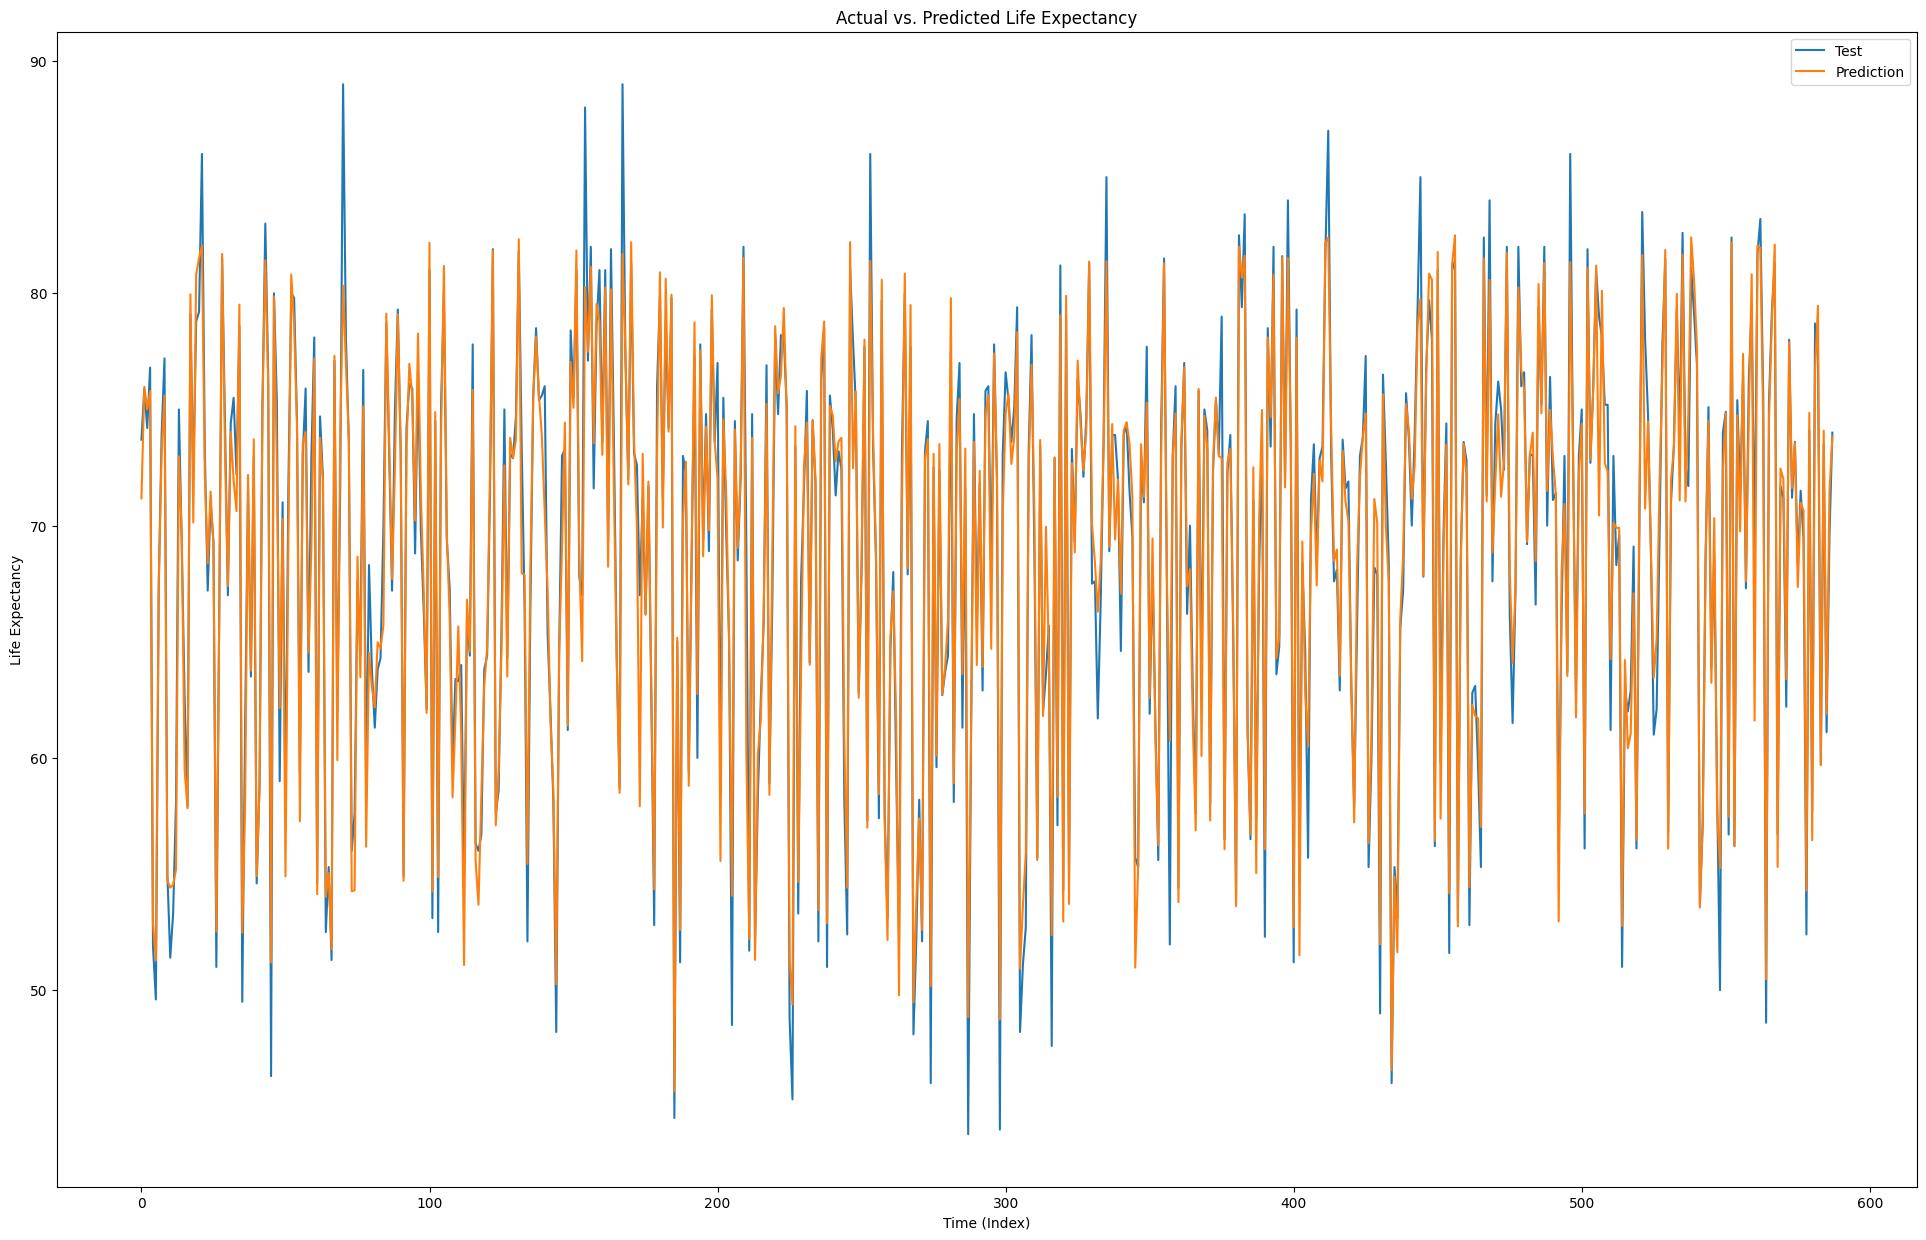

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(24, 15))
plt.plot(y_test_fnn, label='Test')
plt.plot(meta_predictions, label='Prediction')
plt.legend(loc='best')
plt.xlabel('Time (Index)')
plt.ylabel('Life Expectancy')
plt.title('Actual vs. Predicted Life Expectancy')
plt.show()

19/19 [==============================] - 0s 2ms/step
Epoch 1/300, Train R2: -797.2718, Val R2: -801.1556
19/19 [==============================] - 0s 2ms/step
Epoch 2/300, Train R2: -7.7777, Val R2: -8.7149
19/19 [==============================] - 0s 2ms/step
Epoch 3/300, Train R2: -101.8281, Val R2: -102.7177
19/19 [==============================] - 0s 2ms/step
Epoch 4/300, Train R2: -0.1945, Val R2: -0.3847
19/19 [==============================] - 0s 2ms/step
Epoch 5/300, Train R2: -796.3951, Val R2: -761.7124
19/19 [==============================] - 0s 2ms/step
Epoch 6/300, Train R2: -9.2936, Val R2: -10.3715
19/19 [==============================] - 0s 2ms/step
Epoch 7/300, Train R2: 0.3387, Val R2: 0.1787
19/19 [==============================] - 0s 2ms/step
Epoch 8/300, Train R2: 0.5979, Val R2: 0.6021
19/19 [==============================] - 0s 3ms/step
Epoch 9/300, Train R2: 0.5991, Val R2: 0.6331
19/19 [==============================] - 0s 2ms/step
Epoch 10/300, Train R2: 0.5801,

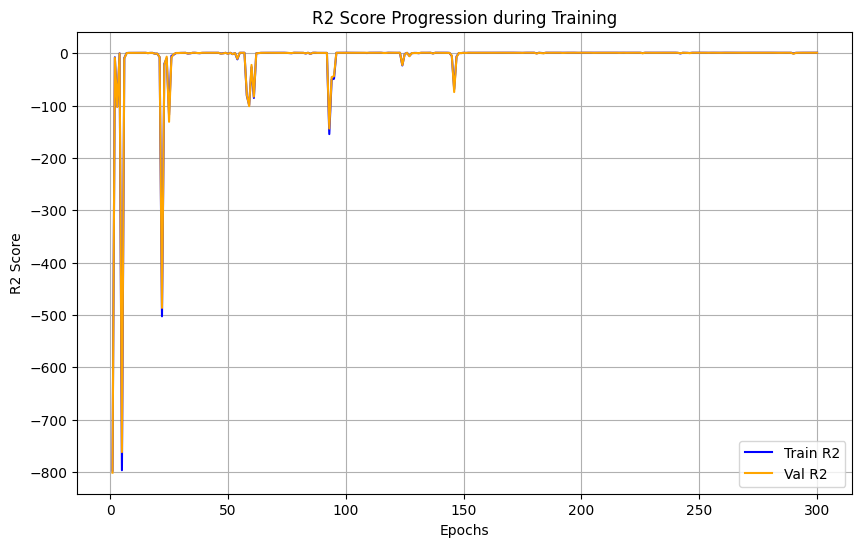

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt


# Identify categorical columns and encode them (example using one-hot encoding)
X_encoded = pd.get_dummies(X, columns=['Country', 'Status'])

# Convert target variable (y) to a NumPy array
y = np.array(y)

# Split the data into training and testing sets for the FNN and GBM models
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the numerical features (excluding the encoded categorical features) for the FNN
numerical_features = X_train_fnn.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train_fnn[numerical_features] = scaler.fit_transform(X_train_fnn[numerical_features])
X_test_fnn[numerical_features] = scaler.transform(X_test_fnn[numerical_features])

# Define the function to create a more complex Feedforward Neural Network (FNN) model
def create_complex_fnn_model(dense_units_1=128, dense_units_2=64, learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(dense_units_1, activation='relu', input_shape=(X_train_fnn.shape[1],)),
        keras.layers.Dense(dense_units_2, activation='relu'),
        keras.layers.Dense(1)  # Output layer with a single neuron for regression
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the FNN model with more complex architecture
fnn_model = create_complex_fnn_model()

# Lists to store R2 values during training
train_r2_values = []
val_r2_values = []

# Train the model on the training data
num_epochs = 300
for epoch in range(num_epochs):
    history = fnn_model.fit(X_train_fnn, y_train_fnn, epochs=1, batch_size=32, validation_split=0.1, verbose=0)
    y_train_pred = fnn_model.predict(X_train_fnn).flatten()
    y_val_pred = fnn_model.predict(X_test_fnn).flatten()
    train_r2 = r2_score(y_train_fnn, y_train_pred)
    val_r2 = r2_score(y_test_fnn, y_val_pred)
    train_r2_values.append(train_r2)
    val_r2_values.append(val_r2)
    print(f"Epoch {epoch+1}/{num_epochs}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}")

# Make predictions on the test data using the FNN
fnn_predictions = fnn_model.predict(X_test_fnn).flatten()

# Initialize the Gradient Boosting Regressor with your preferred hyperparameters
# You can adjust the hyperparameters like 'n_estimators', 'learning_rate', 'max_depth', etc.
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the GBM model on the scaled training data and target
gbm.fit(X_train_fnn, y_train_fnn)

# Make predictions on the test data using the GBM
gbm_predictions = gbm.predict(X_test_fnn)

# Combine the predictions from both models as extended features for the meta-model
X_test_combined = pd.DataFrame({'FNN_Prediction': fnn_predictions, 'GBM_Prediction': gbm_predictions})

# Define the meta-model (FNN) to combine the predictions
def create_meta_model(dense_units_1=64, dense_units_2=32, learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(dense_units_1, activation='relu', input_shape=(X_test_combined.shape[1],)),
        keras.layers.Dense(dense_units_2, activation='relu'),
        keras.layers.Dense(1)  # Output layer with a single neuron for regression
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the meta-model (FNN) and train it on the combined feature set
meta_model = create_meta_model()

# Train the meta-model
meta_model.fit(X_test_combined, y_test_fnn, epochs=100, batch_size=32, verbose=0)

# Make predictions using the meta-model
meta_predictions = meta_model.predict(X_test_combined).flatten()

# Evaluate the performance of the meta-model
mse_meta = mean_squared_error(y_test_fnn, meta_predictions)
r2_meta = r2_score(y_test_fnn, meta_predictions)

print(f"Meta-Model Mean Squared Error: {mse_meta}")
print(f"Meta-Model R-squared (R2): {r2_meta}")

# Plot the R2 values during training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_r2_values, label='Train R2', color='blue')
plt.plot(range(1, num_epochs + 1), val_r2_values, label='Val R2', color='orange')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('R2 Score Progression during Training')
plt.legend()
plt.grid(True)
plt.show()


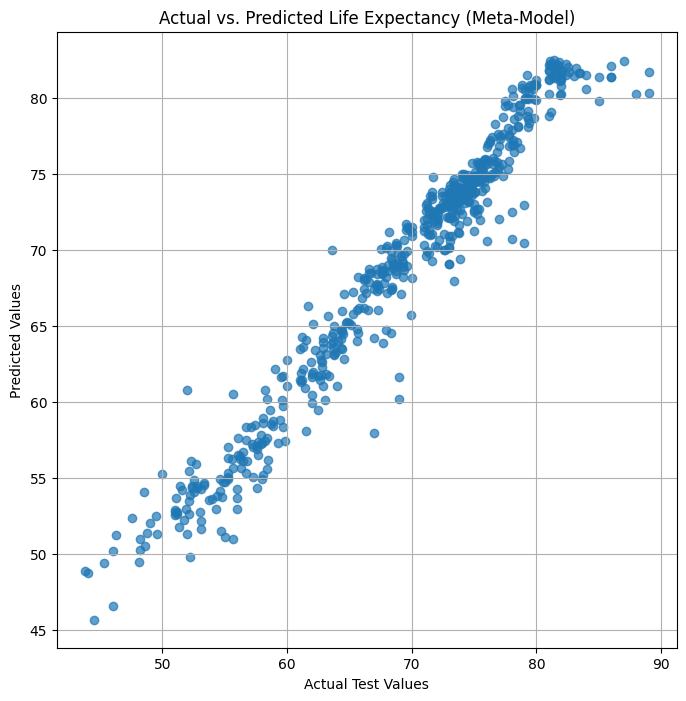

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.scatter(y_test_fnn, meta_predictions, alpha=0.7)
plt.xlabel('Actual Test Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Life Expectancy (Meta-Model)')
plt.grid(True)
plt.show()
